# Machine Learning in Crowd Modelling and Simulation
# Final Project
# Task 4: Extended Dynamic Model Decomposition - Limit Cycle

### Group M:
1. Muhammad Waleed Bin Khalid
2. Qais Hamarneh
3. Yiming Zhang

# Useful Imports

In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import scipy
from EDMD import EDMD
from tqdm import tqdm
from Observables import *
from utils import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## The Limit Cycle

$$
\begin{array}{r}
\dot{y}_{0}=-y_{1}+y_{0}\left(\mu-y_{0}^{2}-y_{1}^{2}\right) \\
\dot{y}_{1}=y_{0}+y_{1}\left(\mu-y_{0}^{2}-y_{1}^{2}\right)
\end{array}
$$

In [2]:
def limit_cycle(t, y):
    """ODE system."""
    mu = 1
    y_dot = np.zeros(2)

    factor = mu - y[0] ** 2 - y[1] ** 2

    y_dot[0] = -y[1] + y[0] * factor
    y_dot[1] = y[0] + y[1] * factor
    return y_dot

In [83]:
t_eval = np.linspace(0, 0.4, 21)

initial_conditions = np.array(
    np.meshgrid(np.linspace(-2, 2, 8), np.linspace(-2, 2, 8))
).T.reshape(-1, 2)
solution_df = pd.DataFrame()

for index, ic in enumerate(initial_conditions):
    solution = solve_ivp(limit_cycle, t_span=(t_eval[0], t_eval[-1]), y0=ic, t_eval=t_eval)
    solution_x = pd.DataFrame(data=solution["y"][:,:-1].T, columns=["x1", "x2"])
    solution_y = pd.DataFrame(data=solution["y"][:,1:].T, columns=["y1", "y2"])
    combined_df = pd.concat([solution_x, solution_y], axis=1)
    combined_df.insert(0, 'ID', index)
    combined_df.insert(1, 'time', solution['t'][:-1])
    solution_df = pd.concat([solution_df, combined_df])
solution_df 

,ID,time,x1,x2,y1,y2
0,0,0.00,-2.000000,-2.000000,-1.735789,-1.806650
1,0,0.02,-1.735789,-1.806650,-1.547156,-1.676108
2,0,0.04,-1.547156,-1.676108,-1.401879,-1.581086
3,0,0.06,-1.401879,-1.581086,-1.286003,-1.510061
4,0,0.08,-1.286003,-1.510061,-1.189672,-1.454757
...,...,...,...,...,...,...
15,63,0.30,0.647749,1.227456,0.612206,1.218410
16,63,0.32,0.612206,1.218410,0.578201,1.210363
17,63,0.34,0.578201,1.210363,0.545490,1.203096
18,63,0.36,0.545490,1.203096,0.513883,1.196435


Text(0, 0.5, 'y')

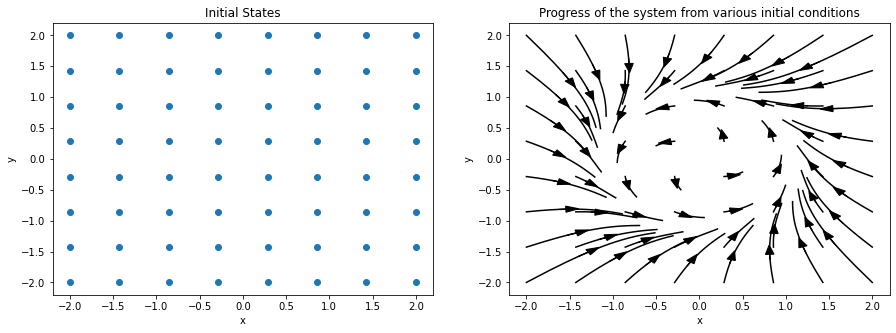

In [84]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].scatter(initial_conditions[:,0], initial_conditions[:,1])
axs[0].set_title('Initial States')
axs[0].set_xlabel('x'); axs[0].set_ylabel('y')
plot_data(solution_df, axs[1])
axs[1].set_title('Progress of the system from various initial conditions')
axs[1].set_xlabel('x'); axs[1].set_ylabel('y')
# fig.savefig('figures/limit_cycle_analytical.png')

## Using Identity Observables

We first apply the EDMD method with the identity dictionary of observables. As discussed this boils down to the DMD method. Before we show the trajectories we would like to analysize the obtained Koopman matrix.

In [85]:
identity_observables = Identity() # We will use the Hermite Pair dictionary as observables
identity_observables.fit(solution_df.iloc[:,0:3])

,ID,time,x1,x1
0,0,0.00,-2.000000,-2.000000
1,0,0.02,-1.735789,-1.735789
2,0,0.04,-1.547156,-1.547156
3,0,0.06,-1.401879,-1.401879
4,0,0.08,-1.286003,-1.286003
...,...,...,...,...
15,63,0.30,0.647749,0.647749
16,63,0.32,0.612206,0.612206
17,63,0.34,0.578201,0.578201
18,63,0.36,0.545490,0.545490


## On the continuous System 
We know that once we have the Koopman matrix, which in this case will be $K \in \mathbb{R}^{2 \times 2}$ we can get the next state of the system (with the same time delta as in the input data) as 

$$
x_{n+1}=K x_{n}
$$

Even though we had a continuous system we have obtained a discrete one using our algorithm. This can be converted to a continuous one by using a linear dynamical system and approximating it by the forward differences.

\begin{equation*}
\begin{aligned}
\frac{d x}{d t} &=A x \\
\frac{x_{n+1}-x_{n}}{\tau}&=A x_{n}\\
x_{n+1} &=(I+\tau \cdot A) x_{n}\\
A&=\frac{K-I}{\Delta t}
\end{aligned}
\end{equation*}

With this $A$ we can analyze the stable points of the system. The A matrix we get is 

$$
A = \left[\begin{array}{cc}
-\sqrt{2} & 1 \\
-1  & -\sqrt{2}
\end{array}\right] \\
$$

which has eigenvalues $\lambda_{1,2} = [-\sqrt{2} \pm 1j]$. Since the real part of the eigenvalues is negative and we have an imaginary part, a spiral sink trajectory is expected.

In [86]:
dmd = EDMD(solution_df, 2, identity_observables)
dmd.fit()
A = (dmd.koopman_matrix() - np.eye(2))/ 0.02
print(f"K={dmd.koopman_matrix()}")
print(f"A={A}")
print(f"Determinant of governing A matrix is {np.linalg.det(A).real:0.5f}")
print(f"Trace of governing A matrix is {np.trace(A).real:0.5f}")
print(f"Eigenvalues of A are {np.linalg.eig(A)[0]}")

K=[[ 0.97191225-3.98156799e-19j  0.01942801-6.83518986e-18j]
 [-0.01942801+1.76344550e-17j  0.97191225-6.25639627e-19j]]
A=[[-1.40438752-1.99078400e-17j  0.97140048-3.41759493e-16j]
 [-0.97140048+8.81722751e-16j -1.40438752-3.12819814e-17j]]
Determinant of governing A matrix is 2.91592
Trace of governing A matrix is -2.80878
Eigenvalues of A are [-1.40438752+0.97140048j -1.40438752-0.97140048j]


In [102]:
t_range = t_eval[:-1]
x_actual = solution_df[solution_df['ID'] == 1].iloc[:,:3]
initial_values = pd.DataFrame(initial_conditions, columns=['x1', 'x2'])
initial_values.insert(0, 'ID', range(len(initial_values)))
initial_values.insert(1, 'time', 0)
x_predict_dmd = dmd.predict(initial_values, t_range=t_range)
x_predict_dmd

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:09<00:00,  6.46it/s]


,ID,time,x1,x2
0,0.0,0.00,-2.000000,-2.000000
0,0.0,0.02,-1.904968,-1.982681
0,0.0,0.04,-1.812943,-1.964001
0,0.0,0.06,-1.723865,-1.944059
0,0.0,0.08,-1.637676,-1.922946
...,...,...,...,...
0,63.0,0.30,0.863621,1.636437
0,63.0,0.32,0.807571,1.607252
0,63.0,0.34,0.753662,1.577797
0,63.0,0.36,0.701840,1.548122


Text(0, 0.5, 'y')

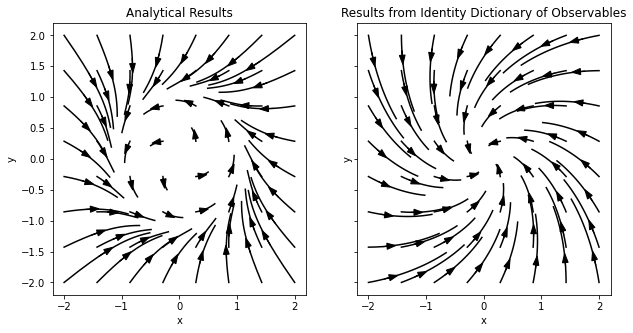

In [98]:
fig, axs = plt.subplots(1,2, sharex=True, sharey=True, figsize=(10,5))
plot_data(solution_df, axs[0])
plot_data(x_predict_dmd, axs[1])
axs[0].set_title('Analytical Results')
axs[0].set_xlabel('x'); axs[0].set_ylabel('y')
axs[1].set_title('Results from Identity Dictionary of Observables')
axs[1].set_xlabel('x'); axs[1].set_ylabel('y')
# fig.savefig('figures/limit_cycle_dmd_sol.png')

## On the Error
As expected, we see that the trajectory is predicted is a spiral sink and does not capture the Hopf ODE system very well. This is because the identity dictionary of observables is unable to capture the non-linearities of the system. We calculate the MSE for a particular trajectory which comes out to be as 0.0813. We subsequently calculated the MSE for all trajectories and took the mean. This came out to be 0.0492.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.81it/s]


MSE for test trajectory is 0.08137666566509959


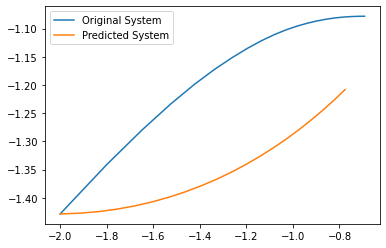

In [133]:
x_actual = solution_df[solution_df['ID'] == 1].iloc[:,:4]
initial_values = x_actual.iloc[0:1,0:4]
x_predict = dmd.predict(initial_values, t_range=t_range)
fig, axs = plt.subplots(1,1, sharex=True, sharey=True)
axs.plot(x_actual.iloc[:,2].to_numpy().real, x_actual.iloc[:,3].to_numpy().real, label='Original System')
axs.plot(x_predict.iloc[:,2].to_numpy().real, x_predict.iloc[:,3].to_numpy(), label='Predicted System')
plt.legend()
fig.savefig('figures/dmd_hopf_traj.png')
mse = mse_calc(x_actual.iloc[:,2:].to_numpy(), x_predict.iloc[:,2:].to_numpy())
print(f"MSE for test trajectory is {mse}")

In [120]:
print(f"MSE for all trajectories combined is {mse_all_traj(solution_df, x_predict_dmd)}")

MSE for all trajectories combined is 0.049245256274945005


## Polynomial Dictionary

In [121]:
polynomial_observables = Polynomials(3)
# polynomial_observables.segregate_observables_from_variable(polynomial_observables.fit(solution_df.iloc[:,0:4]))
polynomial_observables.fit(solution_df.iloc[:,0:4])

,ID,time,x1,x2,x1^0x2^1,x1^0x2^2,x1^0x2^3,x1^1x2^0,x1^1x2^1,x1^1x2^2,x1^2x2^0,x1^2x2^1,x1^3x2^0
0,0,0.00,-2.000000,-2.000000,-2.000000,4.000000,-8.000000,-2.000000,4.000000,-8.000000,4.000000,-8.000000,-8.000000
1,0,0.02,-1.735789,-1.806650,-1.806650,3.263986,-5.896881,-1.735789,3.135963,-5.665589,3.012962,-5.443370,-5.229866
2,0,0.04,-1.547156,-1.676108,-1.676108,2.809339,-4.708757,-1.547156,2.593201,-4.346485,2.393691,-4.012086,-3.703414
3,0,0.06,-1.401879,-1.581086,-1.581086,2.499832,-3.952449,-1.401879,2.216491,-3.504462,1.965264,-3.107252,-2.755063
4,0,0.08,-1.286003,-1.510061,-1.510061,2.280283,-3.443365,-1.286003,1.941942,-2.932450,1.653802,-2.497342,-2.126794
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,63,0.30,0.647749,1.227456,1.227456,1.506648,1.849343,0.647749,0.795083,0.975929,0.419578,0.515014,0.271781
16,63,0.32,0.612206,1.218410,1.218410,1.484522,1.808757,0.612206,0.745917,0.908833,0.374796,0.456655,0.229452
17,63,0.34,0.578201,1.210363,1.210363,1.464978,1.773154,0.578201,0.699833,0.847052,0.334317,0.404644,0.193302
18,63,0.36,0.545490,1.203096,1.203096,1.447439,1.741407,0.545490,0.656277,0.789563,0.297559,0.357992,0.162316


## Fitting EDMD with Polynomial Dictionary of Observables

We will now use the polynomial dictionary of observables in our EDMD algorithm to predict the Hopf system. 

In [122]:
edmd = EDMD(solution_df, 2, polynomial_observables)
edmd.fit()

In [123]:
x_actual = solution_df[solution_df['ID'] == 1].iloc[:,:3]
initial_values = pd.DataFrame(initial_conditions, columns=['x1', 'x2'])
initial_values.insert(0, 'ID', range(len(initial_values)))
initial_values.insert(1, 'time', 0)

In [127]:
x_predict_edmd = edmd.predict(initial_values, t_range=t_range)
x_predict_edmd

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:35<00:00,  1.82it/s]


,ID,time,x1,x2
0,0.0,0.00,-2.000000,-2.000000
0,0.0,0.02,-1.722701,-1.793040
0,0.0,0.04,-1.534981,-1.662759
0,0.0,0.06,-1.393774,-1.571389
0,0.0,0.08,-1.280921,-1.503270
...,...,...,...,...
0,63.0,0.30,0.653733,1.231934
0,63.0,0.32,0.618024,1.222484
0,63.0,0.34,0.583825,1.213943
0,63.0,0.36,0.550947,1.206165


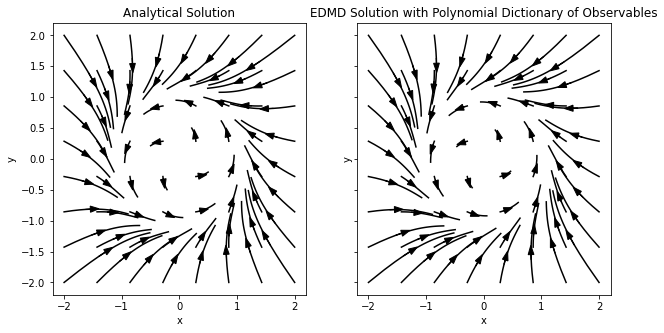

In [126]:
fig, axs = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)
plot_data(solution_df, axs[0])
plot_data(x_predict_edmd, axs[1])
axs[0].set_title('Analytical Solution')
axs[0].set_xlabel('x'); axs[0].set_ylabel('y'); 
axs[1].set_title('EDMD Solution with Polynomial Dictionary of Observables')
axs[1].set_xlabel('x'); axs[1].set_ylabel('y'); 
# fig.savefig('figures/limit_cycle_edmd_sol.png')

## On the Error
We can observe that the trajectories are captured very nicely in the EDMD prediction. We calculate the MSE for a particular trajectory which comes out to be as 0.00006326. We subsequently calculated the MSE for all trajectories and took the mean. This came out to be 0.00009758. This is significantly lower than the MSE from the identity dictionary of observables and hence we see we are able to capture the non-linear dynamics much better with a non-linear dictionary of observables.

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.51it/s]


MSE for test trajectory is 6.32582776683214e-05


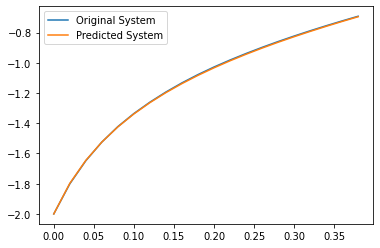

In [132]:
x_actual = solution_df[solution_df['ID'] == 1].iloc[:,:4]
initial_values = x_actual.iloc[0:1,0:4]
x_predict = edmd.predict(initial_values, t_range=t_range)
fig, axs = plt.subplots(1,1, sharex=True, sharey=True)
axs.plot(x_actual.iloc[:,1].to_numpy().real, x_actual.iloc[:,2].to_numpy().real, label='Original System')
axs.plot(x_predict.iloc[:,1].to_numpy().real, x_predict.iloc[:,2].to_numpy(), label='Predicted System')
plt.legend()
fig.savefig('figures/edmd_hopf_traj.png')
mse = mse_calc(x_actual.iloc[:,2:].to_numpy(), x_predict.iloc[:,2:].to_numpy())
print(f"MSE for test trajectory is {mse}")

In [130]:
print(f"MSE for all trajectories combined is {mse_all_traj(solution_df, x_predict_edmd)}")

MSE for all trajectories combined is 9.758126628766088e-05
